In [29]:
import sys
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/rpn/')
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/')

import os
import numpy as np
import json
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

from model.fpn.resnet import resnet101
from data.dataset import BrainDataset, collater
from model.fpn.fpn import FPN 
from model.rpn.generate_anchors import generate_anchors, generate_anchors_all_pyramids


from model.nms.nms import non_max_suppression as nms
from model.rpn.bbox_transform import clip_boxes, bbox_overlaps_batch, bbox_transform_batch, bbox_transform_inv

In [3]:
import sys
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/rpn/')
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/')
import os
import numpy as np
import json
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch


from model.fpn.resnet import resnet101
from data.dataset import BrainDataset, collater
from model.fpn.fpn import FPN, FPN_resnet
from model.rpn.rpn_fpn import _RPN_FPN


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [5]:
with open('./data/train.json', 'r') as file:
    train_json = json.load(file)

with open('./data/valid.json', 'r') as file:
    valid_json = json.load(file)
    
    
train_ds = BrainDataset(train_json)
valid_ds = BrainDataset(valid_json)

train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collater , shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=4, collate_fn=collater , shuffle=True)

In [6]:
x, y = next(iter(train_dl))

batch_size = 16
im_data = x
gt_boxes = y
im_info = torch.FloatTensor(batch_size*[[512,512,1]])
num_boxes = torch.FloatTensor(32)


In [5]:
classes = ['hemmorhage', 'fracture']
model = FPN_resnet(classes)

for name, param in model.named_parameters():
    if 'resnet' in name:
        param.requires_grad = False




In [14]:
model.zero_grad()

rois, cls_prob, bbox_pred, rpn_loss_cls, rpn_loss_box, \
       RCNN_loss_cls, RCNN_loss_bbox, \
       roi_labels = model(im_data, im_info, gt_boxes, num_boxes)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2925: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/kuchoco97/work/fpn_rcnn/model/rpn/rpn_fpn.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
/home/kuchoco97/work/fpn_rcnn/model/fpn/fpn.py:338: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


In [15]:
loss = rpn_loss_box+ rpn_loss_cls + RCNN_loss_bbox + RCNN_loss_cls

In [7]:
resnet = resnet101()

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features=in_features, out_features=2)
param = torch.load('/home/kuchoco97/work/brain/data/backbone/model/epoch20_valloss0.33.pth')
resnet.load_state_dict(param)

resnet.eval()

c1,c2,c3,c4,c5 = resnet.stages()

fpn = FPN(c1,c2,c3,c4,c5)

p2, p3, p4, p5, p6 = fpn(x)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2925: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


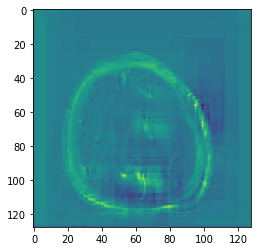

In [8]:
plt.imshow(p2[0,0,:,:].detach().numpy() )

# RPN train

In [7]:
batch_size = 16
rpn = _RPN_FPN(256)
rpn_feature_maps = [p2, p3, p4, p5, p6]
im_info = np.array(batch_size*[[512,512,1]], dtype=np.int32)
gt_boxes = y.data
num_boxes = 16

optimizer = torch.optim.Adam(rpn.parameters())

In [8]:
rois, rpn_loss_cls, rpn_loss_box = rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

loss = rpn_loss_cls + rpn_loss_box
print('loss: ', loss.data)
loss.backward()
optimizer.step()

rois, rpn_loss_cls, rpn_loss_box = rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

loss = rpn_loss_cls + rpn_loss_box
print('loss after step : ', loss.data)

/home/kuchoco97/work/fpn_rcnn/model/rpn/rpn_fpn.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
/home/kuchoco97/work/fpn_rcnn/model/rpn/rpn_fpn.py:105: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:962.)
  rpn_keep = Variable(rpn_label.view(-1).ne(-1).nonzero().view(-1))


loss:  tensor(0.6790, grad_fn=<AddBackward0>)
after step loss:  tensor(0.5396, grad_fn=<AddBackward0>)


In [ ]:
blob = {'data': img,
        'im_info': (shape1,shape2,scale),
        'gt_boxes': bbox,
        'img_id': ids}


data = img
im_info = (shape1,shape2,scale)
gt_boxes = bboxs
__getitem__ return data, im_info,gt_boxes, num_boxes



######################################### Training #################################################
FPN = resnet(imdb.classes, 101, pretrained=True, class_agnostic=args.class_agnostic)
        self.RCNN_cls_score = nn.Linear(1024, self.n_classes)
        self.RCNN_bbox_pred = nn.Linear(1024, 4 * self.n_classes)
        
FPN.zero_grad()
_, _, _, rpn_loss_cls, rpn_loss_box, \
       RCNN_loss_cls, RCNN_loss_bbox, \
       roi_labels = FPN(im_data, im_info, gt_boxes, num_boxes)





####################### _FPN ################
    
from model.rpn.rpn_fpn import _RPN_FPN
from model.roi_pooling.modules.roi_pool import _RoIPooling
from model.roi_crop.modules.roi_crop import _RoICrop
from model.roi_align.modules.roi_align import RoIAlignAvg
from model.rpn.proposal_target_layer import _ProposalTargetLayer
from model.utils.net_utils import _smooth_l1_loss, _crop_pool_layer, _affine_grid_gen, _affine_theta


self.RCNN_rpn = _RPN_FPN(self.dout_base_model)
self.RCNN_proposal_target = _ProposalTargetLayer(self.n_classes)

# NOTE: the original paper used pool_size = 7 for cls branch, and 14 for mask branch, to save the
# computation time, we first use 14 as the pool_size, and then do stride=2 pooling for cls branch.
self.RCNN_roi_pool = _RoIPooling(7, 7, 1.0/16.0)
self.RCNN_roi_align = RoIAlignAvg(7, 7, 1.0/16.0)
self.grid_size = 7 * 2 if cfg.CROP_RESIZE_WITH_MAX_POOL else 7
self.RCNN_roi_crop = _RoICrop()
#####################

########## _FPN forward ##########3
rpn_feature_maps = [p2, p3, p4, p5, p6]
mrcnn_feature_maps = [p2, p3, p4, p5]

rois, rpn_loss_cls, rpn_loss_bbox = self.RCNN_rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

roi_data = self.RCNN_proposal_target(rois, gt_boxes, num_boxes)

rois, rois_label, gt_assign, rois_target, rois_inside_ws, rois_outside_ws = roi_data


rois = rois.view(-1, 5)
rois_label = rois_label.view(-1).long()
gt_assign = gt_assign.view(-1).long()
pos_id = rois_label.nonzero().squeeze()

gt_assign_pos = gt_assign[pos_id]
rois_label_pos = rois_label[pos_id]
rois_label_pos_ids = pos_id

rois_pos = Variable(rois[pos_id])
rois = Variable(rois)
rois_label = Variable(rois_label)

rois_target = Variable(rois_target.view(-1, rois_target.size(2)))
rois_inside_ws = Variable(rois_inside_ws.view(-1, rois_inside_ws.size(2)))
rois_outside_ws = Variable(rois_outside_ws.view(-1, rois_outside_ws.size(2)))





# pooling features based on rois, output 14x14 map
roi_pool_feat = self._PyramidRoI_Feat(mrcnn_feature_maps, rois, im_info)

# feed pooled features to top model
pooled_feat = self._head_to_tail(roi_pool_feat)

# compute bbox offset
bbox_pred = self.RCNN_bbox_pred(pooled_feat)


# select the corresponding columns according to roi labels
bbox_pred_view = bbox_pred.view(bbox_pred.size(0), int(bbox_pred.size(1) / 4), 4)
bbox_pred_select = torch.gather(bbox_pred_view, 1, rois_label.long().view(rois_label.size(0), 1, 1).expand(rois_label.size(0), 1, 4))
bbox_pred = bbox_pred_select.squeeze(1)

# compute object classification probability
cls_score = self.RCNN_cls_score(pooled_feat)
cls_prob = F.softmax(cls_score)


# loss (cross entropy) for object classification
RCNN_loss_cls = F.cross_entropy(cls_score, rois_label)
# loss (l1-norm) for bounding box regression
RCNN_loss_bbox = _smooth_l1_loss(bbox_pred, rois_target, rois_inside_ws, rois_outside_ws)


rois = rois.view(batch_size, -1, rois.size(1))
cls_prob = cls_prob.view(batch_size, -1, cls_prob.size(1))
bbox_pred = bbox_pred.view(batch_size, -1, bbox_pred.size(1))

rois_label = rois_label.view(batch_size, -1)

return rois, cls_prob, bbox_pred, rpn_loss_cls, rpn_loss_bbox, RCNN_loss_cls, RCNN_loss_bbox, rois_label

####################################



loss = rpn_loss_cls.mean() + rpn_loss_box.mean() \
   + RCNN_loss_cls.mean() + RCNN_loss_bbox.mean()
loss_temp += loss.data[0]

# backward
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
_RPN_FPN

rpn_feature_maps = [p2, p3, p4, p5, p6]
mrcnn_feature_maps = [p2, p3, p4, p5]
self.RCNN_rpn = _RPN_FPN(self.dout_base_model)
rois, rpn_loss_cls, rpn_loss_bbox = self.RCNN_rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)







In [138]:
rpn_cls_score_alls.shape

torch.Size([16, 65472, 2])

In [9]:
rpn = _RPN_FPN(256)
rpn_feature_maps = [p2, p3, p4, p5, p6]

n_feat_maps = len(rpn_feature_maps)

rpn_cls_scores = []
rpn_cls_probs = []
rpn_bbox_preds = []
rpn_shapes = []

for i in range(n_feat_maps):
    feat_map = rpn_feature_maps[i]
    batch_size = feat_map.size(0)

    # return feature map after convrelu layer
    rpn_conv1 = F.relu(rpn.RPN_Conv(feat_map), inplace=True)
    # get rpn classification score
    rpn_cls_score = rpn.RPN_cls_score(rpn_conv1)

    rpn_cls_score_reshape = rpn.reshape(rpn_cls_score, 2)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
    rpn_cls_prob = rpn.reshape(rpn_cls_prob_reshape, rpn.nc_score_out)

    # get rpn offsets to the anchor boxes
    rpn_bbox_pred = rpn.RPN_bbox_pred(rpn_conv1)

    rpn_shapes.append([rpn_cls_score.size()[2], rpn_cls_score.size()[3]])
    rpn_cls_scores.append(rpn_cls_score.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2))
    rpn_cls_probs.append(rpn_cls_prob.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2))
    rpn_bbox_preds.append(rpn_bbox_pred.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4))

rpn_cls_score_alls = torch.cat(rpn_cls_scores, 1)
rpn_cls_prob_alls = torch.cat(rpn_cls_probs, 1)
rpn_bbox_pred_alls = torch.cat(rpn_bbox_preds, 1)

n_rpn_pred = rpn_cls_score_alls.size(1)




im_info = np.array(batch_size*[[512,512,1]], dtype=np.int32)
cfg_key= 'TRAIN'

rois = rpn.RPN_proposal((rpn_cls_prob_alls.data, rpn_bbox_pred_alls.data,
                         im_info, cfg_key, rpn_shapes))



<ipython-input-9-8c964493666e>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)


torch.Size([16, 65472])

In [145]:
rpn_label = labels.view(batch_size, -1)

In [149]:
rpn_keep = rpn_label.view(-1).ne(-1).nonzero().view(-1)
rpn_cls_score = torch.index_select(rpn_cls_score_alls.view(-1,2), 0, rpn_keep)
rpn_label = torch.index_select(rpn_label.view(-1), 0, rpn_keep.data)

<ipython-input-149-4d1ab44b7a90>:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:962.)
  rpn_keep = rpn_label.view(-1).ne(-1).nonzero().view(-1)


In [159]:
rpn_cls_score

tensor([[-0.0180,  0.0109],
        [ 0.0453, -0.0158],
        [-0.0027,  0.0210],
        ...,
        [ 0.0361, -0.0087],
        [-0.0302,  0.0276],
        [ 0.0346, -0.0089]], grad_fn=<IndexSelectBackward>)

In [161]:
rpn_label.long()

tensor([0, 0, 0,  ..., 0, 0, 0])

In [162]:
F.cross_entropy(rpn_cls_score, rpn_label.long())

tensor(0.6925, grad_fn=<NllLossBackward>)

In [104]:
_anchor_ratios = [0.5,1,2]
_feat_stride = [16, ]
_fpn_scales = np.array([8, 16, 32, 64, 128])
_fpn_feature_strides = np.array([4, 8, 16, 32, 64])
_fpn_anchor_stride = 1

# allow boxes to sit over the edge by a small amount
_allowed_border = 0  # default is 0


scores = rpn_cls_prob_alls.data
gt_boxes = y.data
im_info = np.array([batch_size*[512,512,1]], dtype=np.int32)
num_boxes = 1
feat_shapes = rpn_shapes

# NOTE: need to change
# height, width = scores.size(2), scores.size(3)
height, width = 0, 0

batch_size = gt_boxes.size(0)

anchors = torch.from_numpy(generate_anchors_all_pyramids(_fpn_scales, _anchor_ratios, 
        feat_shapes, _fpn_feature_strides, _fpn_anchor_stride)).type_as(scores)    
total_anchors = anchors.size(0)




In [129]:
np.where(labels==1)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  4,  5,  5,  6,  6,  7,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
        12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15]),
 array([62997, 62998, 62999, 63672, 63673, 63674, 65109, 65110, 65167,
        65168, 65365, 65359, 65416, 64770, 64771, 64818, 64819, 64836,
        64911, 64959, 65031, 65122, 65170, 65171, 65388, 65385, 62523,
        65361, 64956, 64957, 64838, 65109, 65110, 65167, 65168, 65365,
        65366, 59415, 59607, 64878, 64879, 62808, 62809, 62810, 65125,
        65126, 65345, 65394, 65337, 65338, 65339, 65320, 64776, 61775,
        61778, 64686, 64687, 65109, 65110, 65157, 65158, 65334, 65335,
        65406, 65430, 63309]))

In [128]:
sum_fg

tensor([11,  2, 11,  1,  1,  2,  2,  1,  6,  4,  7,  3,  1,  1, 12,  1])

In [123]:
gt_boxes[0]

tensor([[201., 129., 332., 215.,   0.],
        [ 94., 246., 124., 276.,   0.],
        [104., 355., 141., 391.,   0.],
        [200., 329., 268., 412.,   0.],
        [266., 392., 378., 451.,   0.]])

In [127]:
# keep = ((anchors[:, 0] >= -_allowed_border) &
#         (anchors[:, 1] >= -_allowed_border) &
#         (anchors[:, 2] < (im_info[0][1]) + _allowed_border) &
#         (anchors[:, 3] < (im_info[0][0]) + _allowed_border))

# inds_inside = torch.nonzero(keep).view(-1)

# # keep only inside anchors
# anchors = anchors[inds_inside, :]

anchors.clip_(0, 512)

# label: 1 is positive, 0 is negative, -1 is dont care
labels = gt_boxes.new(batch_size, anchors.size(0)).fill_(-1)
bbox_inside_weights = gt_boxes.new(batch_size, anchors.size(0)).zero_()
bbox_outside_weights = gt_boxes.new(batch_size, anchors.size(0)).zero_()

overlaps = bbox_overlaps_batch(anchors, gt_boxes)

max_overlaps, argmax_overlaps = torch.max(overlaps, 2)
gt_max_overlaps, _ = torch.max(overlaps, 1)

if not False:
    labels[max_overlaps < 0.3] = 0

gt_max_overlaps[gt_max_overlaps==0] = 1e-5
keep = torch.sum(overlaps.eq(gt_max_overlaps.view(batch_size,1,-1).expand_as(overlaps)), 2)

if torch.sum(keep) > 0:
    labels[keep>0] = 1

# fg label: above threshold IOU
labels[max_overlaps >= 0.5] = 1

if False:
    labels[max_overlaps < 0.3] = 0

num_fg = int(0.5 * 256)

sum_fg = torch.sum((labels == 1).int(), 1)
sum_bg = torch.sum((labels == 0).int(), 1)

for i in range(batch_size):
    # subsample positive labels if we have too many
    if sum_fg[i] > num_fg:
        fg_inds = torch.nonzero(labels[i] == 1).view(-1)
        # torch.randperm seems has a bug on multi-gpu setting that cause the segfault. 
        # See https://github.com/pytorch/pytorch/issues/1868 for more details.
        # use numpy instead.                
        #rand_num = torch.randperm(fg_inds.size(0)).type_as(gt_boxes).long()
        rand_num = torch.from_numpy(np.random.permutation(fg_inds.size(0))).type_as(gt_boxes).long()
        disable_inds = fg_inds[rand_num[:fg_inds.size(0)-num_fg]]
        labels[i][disable_inds] = -1

    num_bg = 256 - sum_fg[i]

    # subsample negative labels if we have too many
    if sum_bg[i] > num_bg:
        bg_inds = torch.nonzero(labels[i] == 0).view(-1)
        #rand_num = torch.randperm(bg_inds.size(0)).type_as(gt_boxes).long()

        rand_num = torch.from_numpy(np.random.permutation(bg_inds.size(0))).type_as(gt_boxes).long()
        disable_inds = bg_inds[rand_num[:bg_inds.size(0)-num_bg]]
        labels[i][disable_inds] = -1

offset = torch.arange(0, batch_size)*gt_boxes.size(1)

argmax_overlaps = argmax_overlaps + offset.view(batch_size, 1).type_as(argmax_overlaps)
bbox_targets = _compute_targets_batch(anchors, gt_boxes.view(-1,5)[argmax_overlaps.view(-1), :].view(batch_size, -1, 5))

# use a single value instead of 4 values for easy index.
bbox_inside_weights[labels==1] = (1.0, 1.0, 1.0, 1.0)[0]

if -1.0 < 0:
    num_examples = torch.sum(labels[i] >= 0)
    positive_weights = 1.0 / num_examples
    negative_weights = 1.0 / num_examples
# else:
#     assert ((cfg.TRAIN.RPN_POSITIVE_WEIGHT > 0) &
#             (cfg.TRAIN.RPN_POSITIVE_WEIGHT < 1))

bbox_outside_weights[labels == 1] = positive_weights
bbox_outside_weights[labels == 0] = negative_weights




bbox_outside_weights[labels == 1] = positive_weights
bbox_outside_weights[labels == 0] = negative_weights

# labels = _unmap(labels, total_anchors, inds_inside, batch_size, fill=-1)
# bbox_targets = _unmap(bbox_targets, total_anchors, inds_inside, batch_size, fill=0)
# bbox_inside_weights = _unmap(bbox_inside_weights, total_anchors, inds_inside, batch_size, fill=0)
# bbox_outside_weights = _unmap(bbox_outside_weights, total_anchors, inds_inside, batch_size, fill=0)

outputs = []

# labels = labels.view(batch_size, height, width, A).permute(0,3,1,2).contiguous()
# labels = labels.view(batch_size, 1, A * height, width)
outputs.append(labels)
# bbox_targets = bbox_targets.view(batch_size, height, width, A*4).permute(0,3,1,2).contiguous()
outputs.append(bbox_targets)

# anchors_count = bbox_inside_weights.size(1)
# bbox_inside_weights = bbox_inside_weights.view(batch_size,anchors_count,1).expand(batch_size, anchors_count, 4)
# bbox_inside_weights = bbox_inside_weights.contiguous().view(batch_size, height, width, 4*A)\
                    # .permute(0,3,1,2).contiguous()

outputs.append(bbox_inside_weights)

# bbox_outside_weights = bbox_outside_weights.view(batch_size,anchors_count,1).expand(batch_size, anchors_count, 4)
# bbox_outside_weights = bbox_outside_weights.contiguous().view(batch_size, height, width, 4*A)\
                    # .permute(0,3,1,2).contiguous()
outputs.append(bbox_outside_weights)

In [142]:
bbox_targets[0][62997]

tensor([-0.1270,  0.1081,  0.2716, -0.4002])

In [31]:
def _unmap(data, count, inds, batch_size, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """

    if data.dim() == 2:
        ret = torch.Tensor(batch_size, count).fill_(fill).type_as(data)
        ret[:, inds] = data
    else:
        ret = torch.Tensor(batch_size, count, data.size(2)).fill_(fill).type_as(data)
        ret[:, inds,:] = data
    return ret


def _compute_targets_batch(ex_rois, gt_rois):
    """Compute bounding-box regression targets for an image."""

    return bbox_transform_batch(ex_rois, gt_rois[:, :, :4])


In [137]:
max_overlaps.shape

torch.Size([16, 65472])

In [138]:
overlaps.size()

torch.Size([16, 65472, 5])

In [18]:
N = anchors.size(0)
K = gt_boxes.size(1)

anchors = anchors.view(1, N, 4).expand(batch_size, N, 4).contiguous()
gt_boxes = gt_boxes[:,:,:4].contiguous()


gt_boxes_x = (gt_boxes[:,:,2] - gt_boxes[:,:,0] + 1)
gt_boxes_y = (gt_boxes[:,:,3] - gt_boxes[:,:,1] + 1)
gt_boxes_area = (gt_boxes_x * gt_boxes_y).view(batch_size, 1, K)

anchors_boxes_x = (anchors[:,:,2] - anchors[:,:,0] + 1)
anchors_boxes_y = (anchors[:,:,3] - anchors[:,:,1] + 1)
anchors_area = (anchors_boxes_x * anchors_boxes_y).view(batch_size, N, 1)

gt_area_zero = (gt_boxes_x == 1) & (gt_boxes_y == 1)
anchors_area_zero = (anchors_boxes_x == 1) & (anchors_boxes_y == 1)

boxes = anchors.view(batch_size, N, 1, 4).expand(batch_size, N, K, 4)
query_boxes = gt_boxes.view(batch_size, 1, K, 4).expand(batch_size, N, K, 4)

iw = (torch.min(boxes[:,:,:,2], query_boxes[:,:,:,2]) -
    torch.max(boxes[:,:,:,0], query_boxes[:,:,:,0]) + 1)
iw[iw < 0] = 0

ih = (torch.min(boxes[:,:,:,3], query_boxes[:,:,:,3]) -
    torch.max(boxes[:,:,:,1], query_boxes[:,:,:,1]) + 1)
ih[ih < 0] = 0
ua = anchors_area + gt_boxes_area - (iw * ih)
overlaps = iw * ih / ua

# mask the overlap here.
overlaps.masked_fill_(gt_area_zero.view(batch_size, 1, K).expand(batch_size, N, K), 0)
overlaps.masked_fill_(anchors_area_zero.view(batch_size, N, 1).expand(batch_size, N, K), -1)


tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0043, 0.0000, 0.0000, 0.0000],
         [0.0089, 0.0000, 0.0000, 0.0000],
         [0.0116, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from model.rpn.bbox_transform import bbox_overlaps_batch, bbox_transform_batch

class _ProposalTargetLayer(nn.Module):
    """
    Assign object detection proposals to ground-truth targets. Produces proposal
    classification labels and bounding-box regression targets.
    """

    def __init__(self, nclasses):
        super(_ProposalTargetLayer, self).__init__()
        self._num_classes = nclasses
        self.BBOX_NORMALIZE_MEANS = torch.FloatTensor((0.0, 0.0, 0.0, 0.0))
        self.BBOX_NORMALIZE_STDS = torch.FloatTensor((0.1, 0.1, 0.2, 0.2))
        self.BBOX_INSIDE_WEIGHTS = torch.FloatTensor((1.0, 1.0, 1.0, 1.0))

    def forward(self, all_rois, gt_boxes, num_boxes):

        self.BBOX_NORMALIZE_MEANS = self.BBOX_NORMALIZE_MEANS.type_as(gt_boxes)
        self.BBOX_NORMALIZE_STDS = self.BBOX_NORMALIZE_STDS.type_as(gt_boxes)
        self.BBOX_INSIDE_WEIGHTS = self.BBOX_INSIDE_WEIGHTS.type_as(gt_boxes)

        gt_boxes_append = gt_boxes.new(gt_boxes.size()).zero_()
        gt_boxes_append[:,:,1:5] = gt_boxes[:,:,:4]

        # Include ground-truth boxes in the set of candidate rois
        all_rois = torch.cat([all_rois, gt_boxes_append], 1)

        num_images = 1
        # rois_per_image = int(cfg.TRAIN.BATCH_SIZE / num_images)
        rois_per_image = int( 16 / num_images)   # batch_size = 16
        fg_rois_per_image = int(np.round(0.25 * rois_per_image))

        labels, rois, gt_assign, bbox_targets, bbox_inside_weights = self._sample_rois_pytorch(
            all_rois, gt_boxes, fg_rois_per_image,
            rois_per_image, self._num_classes)

        bbox_outside_weights = (bbox_inside_weights > 0).float()

        return rois, labels, gt_assign, bbox_targets, bbox_inside_weights, bbox_outside_weights

    def backward(self, top, propagate_down, bottom):
        """This layer does not propagate gradients."""
        pass

    def reshape(self, bottom, top):
        """Reshaping happens during the call to forward."""
        pass

    def _get_bbox_regression_labels_pytorch(self, bbox_target_data, labels_batch, num_classes):
        """Bounding-box regression targets (bbox_target_data) are stored in a
        compact form b x N x (class, tx, ty, tw, th)
        This function expands those targets into the 4-of-4*K representation used
        by the network (i.e. only one class has non-zero targets).
        Returns:
            bbox_target (ndarray): b x N x 4K blob of regression targets
            bbox_inside_weights (ndarray): b x N x 4K blob of loss weights
        """
        batch_size = labels_batch.size(0)
        rois_per_image = labels_batch.size(1)
        clss = labels_batch
        bbox_targets = bbox_target_data.new(batch_size, rois_per_image, 4).zero_()
        bbox_inside_weights = bbox_target_data.new(bbox_targets.size()).zero_()

        for b in range(batch_size):
            # assert clss[b].sum() > 0
            if clss[b].sum() == 0:
                continue
            inds = torch.nonzero(clss[b] > 0).view(-1)
            for i in range(inds.numel()):
                ind = inds[i]
                bbox_targets[b, ind, :] = bbox_target_data[b, ind, :]
                bbox_inside_weights[b, ind, :] = self.BBOX_INSIDE_WEIGHTS

        return bbox_targets, bbox_inside_weights


    def _compute_targets_pytorch(self, ex_rois, gt_rois):
        """Compute bounding-box regression targets for an image."""

        assert ex_rois.size(1) == gt_rois.size(1)
        assert ex_rois.size(2) == 4
        assert gt_rois.size(2) == 4

        batch_size = ex_rois.size(0)
        rois_per_image = ex_rois.size(1)

        targets = bbox_transform_batch(ex_rois, gt_rois)

        if True:
            # Optionally normalize targets by a precomputed mean and stdev
            targets = ((targets - self.BBOX_NORMALIZE_MEANS.expand_as(targets))
                        / self.BBOX_NORMALIZE_STDS.expand_as(targets))

        return targets


    def _sample_rois_pytorch(self, all_rois, gt_boxes, fg_rois_per_image, rois_per_image, num_classes):
        """Generate a random sample of RoIs comprising foreground and background
        examples.
        """
        # overlaps: (rois x gt_boxes)

        overlaps = bbox_overlaps_batch(all_rois, gt_boxes)
        
        max_overlaps, gt_assignment = torch.max(overlaps, 2)

        batch_size = overlaps.size(0)
        num_proposal = overlaps.size(1)
        num_boxes_per_img = overlaps.size(2)

        offset = torch.arange(0, batch_size)*gt_boxes.size(1)
        offset = offset.view(-1, 1).type_as(gt_assignment) + gt_assignment

        labels = gt_boxes[:,:,4].contiguous().view(-1)[(offset.view(-1))].view(batch_size, -1)

        labels_batch = labels.new(batch_size, rois_per_image).zero_()
        rois_batch  = all_rois.new(batch_size, rois_per_image, 5).zero_()
        gt_assign_batch = all_rois.new(batch_size, rois_per_image).zero_()
        gt_rois_batch = all_rois.new(batch_size, rois_per_image, 5).zero_()
        # Guard against the case when an image has fewer than max_fg_rois_per_image
        # foreground RoIs
        for i in range(batch_size):

            fg_inds = torch.nonzero(max_overlaps[i] >= 0.5).view(-1)
            fg_num_rois = fg_inds.numel()

            # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
            bg_inds = torch.nonzero((max_overlaps[i] < 0.5) &
                                    (max_overlaps[i] >= 0.1)).view(-1)
            bg_num_rois = bg_inds.numel()

            if fg_num_rois > 0 and bg_num_rois > 0:
                # sampling fg
                fg_rois_per_this_image = min(fg_rois_per_image, fg_num_rois)

                # torch.randperm seems has a bug on multi-gpu setting that cause the segfault.
                # See https://github.com/pytorch/pytorch/issues/1868 for more details.
                # use numpy instead.
                #rand_num = torch.randperm(fg_num_rois).long().cuda()
                rand_num = torch.from_numpy(np.random.permutation(fg_num_rois)).type_as(gt_boxes).long()
                fg_inds = fg_inds[rand_num[:fg_rois_per_this_image]]

                # sampling bg
                bg_rois_per_this_image = rois_per_image - fg_rois_per_this_image

                # Seems torch.rand has a bug, it will generate very large number and make an error.
                # We use numpy rand instead.
                #rand_num = (torch.rand(bg_rois_per_this_image) * bg_num_rois).long().cuda()
                rand_num = np.floor(np.random.rand(bg_rois_per_this_image) * bg_num_rois)
                rand_num = torch.from_numpy(rand_num).type_as(gt_boxes).long()
                bg_inds = bg_inds[rand_num]

            elif fg_num_rois > 0 and bg_num_rois == 0:
                # sampling fg
                #rand_num = torch.floor(torch.rand(rois_per_image) * fg_num_rois).long().cuda()
                rand_num = np.floor(np.random.rand(rois_per_image) * fg_num_rois)
                rand_num = torch.from_numpy(rand_num).type_as(gt_boxes).long()
                fg_inds = fg_inds[rand_num]
                fg_rois_per_this_image = rois_per_image
                bg_rois_per_this_image = 0
            elif bg_num_rois > 0 and fg_num_rois == 0:
                # sampling bg
                #rand_num = torch.floor(torch.rand(rois_per_image) * bg_num_rois).long().cuda()
                rand_num = np.floor(np.random.rand(rois_per_image) * bg_num_rois)
                rand_num = torch.from_numpy(rand_num).type_as(gt_boxes).long()

                bg_inds = bg_inds[rand_num]
                bg_rois_per_this_image = rois_per_image
                fg_rois_per_this_image = 0
            else:
                raise ValueError("bg_num_rois = 0 and fg_num_rois = 0, this should not happen!")

            # The indices that we're selecting (both fg and bg)
            keep_inds = torch.cat([fg_inds, bg_inds], 0)

            # Select sampled values from various arrays:
            labels_batch[i].copy_(labels[i][keep_inds])

            # Clamp labels for the background RoIs to 0
            labels_batch[i][fg_rois_per_this_image:] = 0

            rois_batch[i] = all_rois[i][keep_inds]
            rois_batch[i,:,0] = i

            # TODO: check the below line when batch_size > 1, no need to add offset here
            gt_assign_batch[i] = gt_assignment[i][keep_inds]

            gt_rois_batch[i] = gt_boxes[i][gt_assignment[i][keep_inds]]

        bbox_target_data = self._compute_targets_pytorch(
                rois_batch[:,:,1:5], gt_rois_batch[:,:,:4])

        bbox_targets, bbox_inside_weights = \
                self._get_bbox_regression_labels_pytorch(bbox_target_data, labels_batch, num_classes)

        return labels_batch, rois_batch, gt_assign_batch, bbox_targets, bbox_inside_weights

In [ ]:
rois, rpn_loss_cls, rpn_loss_bbox = self.RCNN_rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

# if it is training phrase, then use ground trubut bboxes for refining
if self.training:
    roi_data = self.RCNN_proposal_target(rois, gt_boxes, num_boxes)

In [2]:
classes = ['hemmorhage', 'fracture']

model = FPN_resnet(classes)

for name, param in model.named_parameters():
    if 'resnet' in name:
        param.requires_grad = False